In [1]:
import pandas as pd
import numpy as np
import numba
import time
import yfinance as yf
import matplotlib.pyplot as plt
from quantitative_finance.portfolio.portfolio import Portfolio
from quantitative_finance.backtest.date_utils import PeriodDateCalculator
import dotenv
from eodhd import APIClient
import os

dotenv.load_dotenv(dotenv_path="../.env")

True

In [2]:
api_key = os.environ.get("EODHD_API_KEY")
api = APIClient(api_key)

In [3]:
# Define the ticker symbols
tickers = ["SPY", "EFA", "EEM", "AGG"]
start_date = '2000-01-01'
end_date = '2023-08-01'
frequency = 'd'

In [4]:
price_data = {}
adjusted_close_df = pd.DataFrame()

for idx, ticker in enumerate(tickers):
    response = api.get_eod_historical_stock_market_data(symbol=ticker, period='d', from_date=start_date,
                                                        to_date=end_date, order='a')
    price_df = pd.DataFrame(response)
    price_df['date'] = pd.to_datetime(price_df['date'])
    price_df = price_df.set_index('date')

    if idx == 0:
        adjusted_close_df.index = price_df.index

    adjusted_close_df[ticker] = price_df['adjusted_close'].astype(float)

    price_data[ticker] = pd.DataFrame(response)

In [5]:
total_return_df = adjusted_close_df.pct_change().dropna()

In [6]:
# Generate random weights for each month that sum to 1
np.random.seed(0)  # for reproducibility
number_of_trades = 20
random_weights = np.random.rand(number_of_trades, len(tickers))
random_weights /= random_weights.sum(axis=1)[:, np.newaxis]

weight_dates = np.sort(np.random.choice(total_return_df.index, size=number_of_trades - 1, replace=False))
weight_dates = np.insert(weight_dates, 0, total_return_df.index[0])

# Create a DataFrame for trades with dates as index and tickers as columns
trades = pd.DataFrame(random_weights, columns=tickers, index=weight_dates)

trade_dates = trades.index.to_numpy()
positions = trades.columns.to_numpy()
weights_target_arr = trades.to_numpy()
return_dates = total_return_df[positions].index.to_numpy()
position_returns_arr = total_return_df[positions].to_numpy()

In [7]:
port = Portfolio(
    position_returns=total_return_df[positions],
    positions=positions,
    weights_target=trades,
    return_frequency='D'
)

In [8]:
port.weights_target_arr

array([[0.2275677 , 0.29655611, 0.24993822, 0.22593797],
       [0.1766031 , 0.26924493, 0.18241092, 0.37174105],
       [0.36123028, 0.14373357, 0.29677919, 0.19825697],
       [0.34389291, 0.56035414, 0.04300507, 0.05274788],
       [0.0080841 , 0.33291382, 0.31113736, 0.34786472],
       [0.32406883, 0.26464084, 0.15281859, 0.25847173],
       [0.0640631 , 0.34661191, 0.07764701, 0.51167798],
       [0.26418693, 0.20992357, 0.13393189, 0.39195761],
       [0.27462234, 0.34222196, 0.01131228, 0.37184343],
       [0.21442448, 0.21611939, 0.33060629, 0.23884984],
       [0.23128455, 0.2811586 , 0.4488116 , 0.03874524],
       [0.39766289, 0.39997167, 0.12547318, 0.07689227],
       [0.18687207, 0.21547646, 0.33780682, 0.25984466],
       [0.67668801, 0.06986476, 0.14300702, 0.11044021],
       [0.40386721, 0.15662972, 0.28835589, 0.15114718],
       [0.14942755, 0.10374995, 0.61693388, 0.12988862],
       [0.1325213 , 0.24856725, 0.55345295, 0.0654585 ],
       [0.35220289, 0.04039184,

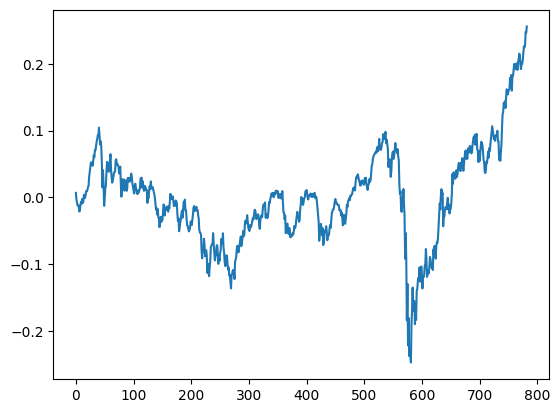

In [9]:
plt.plot(port.trades[16].cumulative_returns())

In [10]:
port.trades[0].weights

array([[0.2275677 , 0.29655611, 0.24993822, 0.22593797],
       [0.1766031 , 0.26924493, 0.18241092, 0.37174105],
       [0.36123028, 0.14373357, 0.29677919, 0.19825697],
       [0.34389291, 0.56035414, 0.04300507, 0.05274788],
       [0.0080841 , 0.33291382, 0.31113736, 0.34786472],
       [0.32406883, 0.26464084, 0.15281859, 0.25847173],
       [0.0640631 , 0.34661191, 0.07764701, 0.51167798],
       [0.26418693, 0.20992357, 0.13393189, 0.39195761],
       [0.27462234, 0.34222196, 0.01131228, 0.37184343],
       [0.21442448, 0.21611939, 0.33060629, 0.23884984],
       [0.23128455, 0.2811586 , 0.4488116 , 0.03874524],
       [0.39766289, 0.39997167, 0.12547318, 0.07689227],
       [0.18687207, 0.21547646, 0.33780682, 0.25984466],
       [0.67668801, 0.06986476, 0.14300702, 0.11044021],
       [0.40386721, 0.15662972, 0.28835589, 0.15114718],
       [0.14942755, 0.10374995, 0.61693388, 0.12988862],
       [0.1325213 , 0.24856725, 0.55345295, 0.0654585 ],
       [0.35220289, 0.04039184,

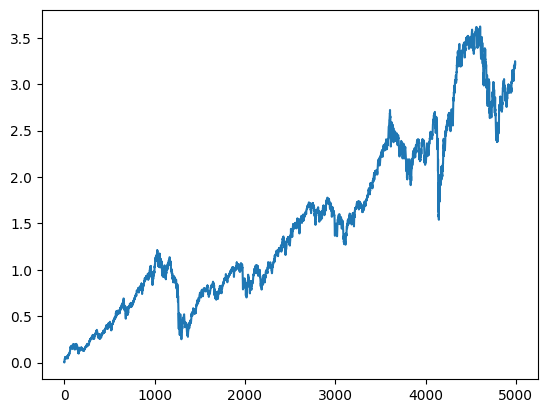

In [11]:
plt.plot(port.backtest.cumulative_performance_arr)

In [12]:
calculator = PeriodDateCalculator(
    total_return_df.index.values,
    return_frequency='D',
    fixed_start=False
)

In [13]:
period_dates = calculator.calc_period_dates()

In [14]:
calculator._default_periods()

OrderedDict([('1M', 0.08333333333333333),
             ('3M', 0.25),
             ('6M', 0.5),
             ('YTD', None),
             ('1Y', 1),
             ('2Y', 2),
             ('3Y', 3),
             ('5Y', 5),
             ('7Y', 7),
             ('10Y', 10),
             ('15Y', 15),
             ('20Y', 20),
             ('Inception', None)])

In [124]:
from quantitative_finance.portfolio.portfolio import Backtest
from dataclasses import dataclass, field
from typing import Union


@dataclass
class BacktestStatistics:
    return_dates: np.ndarray
    returns: np.ndarray
    stat_periods: dict
    return_frequency: str
    benchmark_returns: np.ndarray = None
    fixed_start: bool = False
    create_periodic_stats: bool = True

    def __post_init__(self):
        self.period_calculator = PeriodDateCalculator(
            portfolio_dates=self.return_dates,
            periods=self.stat_periods,
            return_frequency=self.return_frequency,
            fixed_start=self.fixed_start
        )

        self.periods = self.period_calculator.calc_period_dates()
        # self.rolling_windows = self.calc_rolling_windows()

    @staticmethod
    def calc_excess_returns(
            returns,
            benchmark_returns
    ):
        return returns - benchmark_returns

    @staticmethod
    def calc_cumulative_returns(
            returns,
            axis=None
    ):
        return np.exp(np.sum(np.log(returns + 1), axis=axis)) - 1

    @staticmethod
    def calc_std(
            returns,
            axis=None
    ):
        return np.std(returns, axis=axis)

    # TODO: Try using numpy.linalg.lstsq here.
    @staticmethod
    def calc_alpha_beta(
            returns,
            benchmark_returns
    ):
        """
        Calculate alpha and beta of returns compared to a benchmark using vectorized operations.
        This function can handle both single periods and rolling windows of returns.
        
        Args:
        returns (np.array): Array of returns for the asset or portfolio. Can be 1D or 2D.
        benchmark_returns (np.array): Array of returns for the benchmark. Can be 1D or 2D.
        
        Returns:
        tuple: (alpha, beta) if input is 1D, or (alphas, betas) if input is 2D
        """
        # Ensure the arrays are the same shape
        if returns.shape != benchmark_returns.shape:
            raise ValueError("Returns and benchmark returns must have the same shape")

        # Check if we're dealing with a single period or multiple periods
        if returns.ndim == 1:
            # Single period case
            beta, alpha = np.polyfit(benchmark_returns, returns, 1)
            return alpha, beta
        elif returns.ndim == 2:
            # Rolling window case
            n = returns.shape[1]

            # Calculate means
            mean_x = np.mean(benchmark_returns, axis=1)
            mean_y = np.mean(returns, axis=1)

            # Calculate covariance and variance
            cov_xy = np.sum((benchmark_returns - mean_x[:, np.newaxis]) *
                            (returns - mean_y[:, np.newaxis]), axis=1) / n
            var_x = np.sum((benchmark_returns - mean_x[:, np.newaxis]) ** 2, axis=1) / n

            # Calculate betas and alphas
            betas = cov_xy / var_x
            alphas = mean_y - betas * mean_x

            return alphas, betas
        else:
            raise ValueError("Input arrays must be 1D or 2D")

    @staticmethod
    def calc_drawdown(
            returns
    ):
        """
        Calculate the drawdown series and maximum drawdown.

        Args:
        returns (np.array): Array of returns. Can be 1D or 2D.

        Returns:
        tuple: (drawdown_series, max_drawdown)
            drawdown_series is an array of the same shape as returns
            max_drawdown is a float (for 1D input) or an array (for 2D input)
        """
        # Ensure returns is at least 2D
        returns = np.atleast_2d(returns)

        # Calculate cumulative returns
        cum_returns = np.cumprod(1 + returns, axis=1)

        # Calculate running maximum
        running_max = np.maximum.accumulate(cum_returns, axis=1)

        # Calculate drawdown series
        drawdown_series = (cum_returns - running_max) / running_max

        # Calculate maximum drawdown
        max_drawdown = np.min(drawdown_series, axis=1)

        # If input was 1D, return 1D results
        if returns.shape[0] == 1:
            drawdown_series = drawdown_series.squeeze()
            max_drawdown = max_drawdown.item()

        return drawdown_series, max_drawdown

    def calc_sharpe(self):
        pass

    def calc_sortino(self):
        pass

    def calc_treynor_ratio(self):
        pass

    def calc_calmar_ratio(self):
        pass

    @staticmethod
    def calc_var_cvar(
            returns,
            confidence_level=0.95,
            axis=1
    ):
        """
        Calculate the Value at Risk (VaR) and Conditional Value at Risk (CVaR) of a numpy returns array.
    
        Parameters:
        returns (numpy array): Array of returns, can be 1D or 2D
        confidence_level (float): Confidence level for VaR and CVaR (default is 0.95)
        axis (int): Axis along which to calculate VaR and CVaR (default is 1)
    
        Returns:
        tuple: (VaR, CVaR)
        """
        # Sort returns along the specified axis
        sorted_returns = np.sort(returns, axis=axis)

        # Calculate the index corresponding to the confidence level
        index = int((1 - confidence_level) * sorted_returns.shape[axis])

        # VaR is the value at the given confidence level
        var = np.take(sorted_returns, index, axis=axis)

        # CVaR is the average of returns worse than the VaR
        cvar = np.mean(np.take(sorted_returns, range(index), axis=axis), axis=axis)

        return var, cvar

    def calc_periodic_returns(
            self,
            returns,
            annualize=True
    ):
        annualization_func = None
        if annualize:
            annualization_func = self.annualize_return

        return self.calc_periodic_stats(
            returns=returns,
            func=self.calc_cumulative_returns,
            annualization_func=annualization_func
        )

    def calc_periodic_std(
            self,
            returns
    ):
        return self.calc_periodic_stats(
            returns=returns,
            func=self.calc_std
        )

    def calc_periodic_alpha_beta(
            self,
            returns,
            benchmark_returns
    ):
        """Calculate alpha and beta for each period."""
        return self.calc_periodic_stats(
            returns=returns,
            func=self.calc_alpha_beta,
            benchmark_returns=benchmark_returns
        )

    def calc_rolling_alpha_beta(
            self,
            returns,
            benchmark_returns,
            window_size
    ):
        """Calculate rolling alpha and beta."""
        rolling_window_returns = self.get_rolling_window(returns, window_size)
        rolling_window_benchmark = self.get_rolling_window(benchmark_returns, window_size)

        results = np.array([self.calc_alpha_beta(window_returns, window_benchmark)
                            for window_returns, window_benchmark in
                            zip(rolling_window_returns, rolling_window_benchmark)])

        return results[:, 0], results[:, 1]  # alphas, betas

    def calc_periodic_stats(
            self,
            returns,
            func,
            annualization_func=None,
            **kwargs
    ):
        stats_dict = {}
        for period_name, period_info_dict in self.periods.items():
            first_index, last_index = period_info_dict['Indices']
            filtered_returns = returns[first_index:last_index]
            stat = func(
                returns=filtered_returns,
                **kwargs
            )

            if annualization_func:
                number_of_years = period_info_dict['Number of Years']
                if number_of_years > 1:
                    stat = annualization_func(stat, number_of_years)

            stats_dict[period_name] = stat

        return stats_dict

    def calc_rolling_returns(
            self,
            window_size,
    ):

        return self.calc_rolling_stats(
            returns=self.returns,
            func=self.calc_cumulative_returns,
            window_size=window_size,
            axis=1
        )

    def calc_rolling_std(
            self,
            window_size
    ):

        return self.calc_rolling_stats(
            returns=self.returns,
            func=self.calc_std,
            window_size=window_size,
            axis=1
        )

    def calc_rolling_var_cvar(
            self,
            window_size,
    ):

        return self.calc_rolling_stats(
            returns=self.returns,
            func=self.calc_var_cvar,
            window_size=window_size,
            axis=1
        )

    def get_rolling_window(
            self,
            returns,
            window_size,
            periods_in_year=None
    ):

        if periods_in_year is None:
            periods_in_year = 252

        if isinstance(window_size, str):
            window_size = int(self.periods[window_size]['Number of Years'] * periods_in_year)

        if not isinstance(window_size, int):
            raise TypeError(f'window_size must a an int. window_size is {window_size} and type {type(window_size)}')

        return np.lib.stride_tricks.sliding_window_view(returns, window_shape=window_size, axis=0)

    def calc_rolling_stats(
            self,
            func,
            returns,
            window_size,
            periods_in_year=None,
            **kwargs
    ):
        rolling_window = self.get_rolling_window(
            returns=returns,
            window_size=window_size,
            periods_in_year=periods_in_year
        )

        rolling_stat = func(
            returns=rolling_window,
            **kwargs
        )
        return rolling_stat

    def annualize_return(
            self,
            total_return: Union[float, np.ndarray],
            number_of_years: float
    ) -> Union[float, np.ndarray]:
        """
        Annualizes return(s) based on the total return(s) and number of years using NumPy.
    
        This method takes a total return or array of total returns for a given period 
        and annualizes it/them using the number of years in the period. It assumes compound growth.
    
        Args:
            total_return (Union[float, np.ndarray]): The total return(s) for the period as a decimal 
                (e.g., 0.05 for 5%). Can be a single float or a numpy array of floats.
            number_of_years (float): The duration of the period in years.
    
        Returns:
            Union[float, np.ndarray]: The annualized return(s) as a decimal.
                Returns a float if input is a float, or a numpy array if input is a numpy array.
    
        Raises:
            ValueError: If number of years is less than or equal to 1.
    
        Examples:
            >>> total_return_scalar = 0.15
            >>> total_return_array = np.array([0.15, 0.20, 0.25])
            >>> number_of_years = 2.5
            >>> annualized_scalar = self.annualize_return(total_return_scalar, number_of_years)
            >>> annualized_array = self.annualize_return(total_return_array, number_of_years)
            >>> print(f"Annualized return (scalar): {annualized_scalar:.2%}")
            >>> print(f"Annualized returns (array): {annualized_array * 100}")
            Annualized return (scalar): 5.83%
            Annualized returns (array): [ 5.83  7.72  9.59]
        """
        if number_of_years <= 1:
            raise ValueError("Number of years must be greater than 1 for annualization")

        # Calculate the annualized return using NumPy
        annualized_return = np.power(1 + total_return, 1 / number_of_years) - 1

        return annualized_return

    def annualize_std(
            self,
            period_std: Union[float, np.ndarray],
            number_of_periods_in_year: int
    ) -> Union[float, np.ndarray]:
        """
        Annualizes standard deviation(s) based on the period standard deviation(s) using NumPy.
    
        This method takes standard deviation(s) for a given period and annualizes it/them
        using the number of periods in a year. It assumes the standard deviation
        scales with the square root of time.
    
        Args:
            period_std (Union[float, np.ndarray]): The standard deviation(s) for the period as a decimal 
                (e.g., 0.10 for 10%). Can be a single float or a numpy array of floats.
            number_of_periods_in_year (int): The number of periods in a year 
                (e.g., 252 for daily trading, 12 for monthly, 4 for quarterly).
    
        Returns:
            Union[float, np.ndarray]: The annualized standard deviation(s) as a decimal.
                Returns a float if input is a float, or a numpy array if input is a numpy array.
    
        Raises:
            ValueError: If number_of_periods_in_year is less than or equal to 0.
    
        Example:
            >>> period_std_scalar = 0.02  # daily standard deviation
            >>> period_std_array = np.array([0.02, 0.03, 0.04])  # array of daily standard deviations
            >>> number_of_periods_in_year = 252  # assuming 252 trading days in a year
            >>> annualized_scalar = self.annualize_std(period_std_scalar, number_of_periods_in_year)
            >>> annualized_array = self.annualize_std(period_std_array, number_of_periods_in_year)
            >>> print(f"Annualized standard deviation (scalar): {annualized_scalar:.2%}")
            >>> print(f"Annualized standard deviations (array): {annualized_array * 100}")
            Annualized standard deviation (scalar): 31.75%
            Annualized standard deviations (array): [31.75 47.62 63.5 ]
        """
        if number_of_periods_in_year <= 0:
            raise ValueError("Number of periods in year must be greater than 0")

        # Calculate the annualized standard deviation
        annualized_std = period_std * np.sqrt(number_of_periods_in_year)

        return annualized_std

In [125]:
bt_stats = BacktestStatistics(
    return_dates=port.dates,
    returns=port.backtest.portfolio_returns_arr,
    stat_periods=calculator._default_periods(),
    return_frequency=port.return_frequency,
    benchmark_returns=total_return_df['SPY'].to_numpy(),
    fixed_start=False,
    create_periodic_stats=True
)

In [126]:
alphas, betas = bt_stats.calc_rolling_alpha_beta(
    returns=bt_stats.returns,
    benchmark_returns=bt_stats.benchmark_returns,
    window_size=252
)

In [127]:
bt_stats.calc_periodic_alpha_beta(
    returns=bt_stats.returns,
    benchmark_returns=bt_stats.benchmark_returns,
)

ValueError: Returns and benchmark returns must have the same shape

In [130]:
bt_stats.benchmark_returns.shape

(4994,)

In [131]:
bt_stats.returns.shape == bt_stats.benchmark_returns.shape

True

In [112]:
dd, mdd = bt_stats.calc_drawdown(returns=bt_stats.returns)

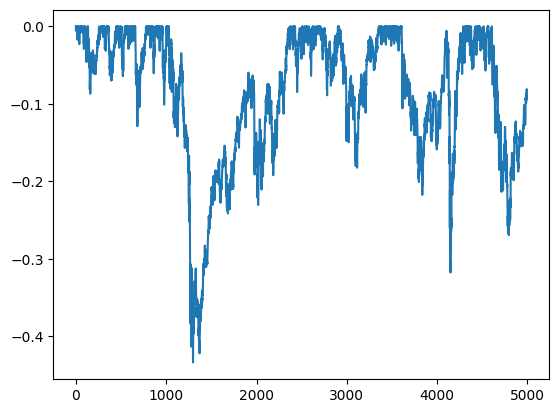

In [118]:
plt.plot(dd)

In [104]:
excess_returns = bt_stats.calc_excess_returns(
    returns=bt_stats.returns,
    benchmark_returns=bt_stats.benchmark_returns
)

In [ ]:
bt_stats.calc_rolling_returns(

)

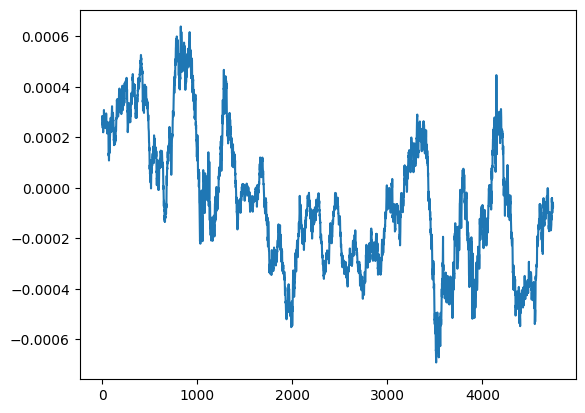

In [97]:
plt.plot(alphas)

In [45]:
bt_stats.calc_periodic_returns(returns=bt_stats.returns)

{'1M': 0.037327939382736375,
 '3M': 0.07095617632481654,
 '6M': 0.06712321649918462,
 'YTD': 0.1298844388400855,
 '1Y': 0.08590724395729188,
 '2Y': -0.022618674290382557,
 '3Y': 0.06358266897917275,
 '5Y': 0.048362973190198,
 '7Y': 0.06834925542731352,
 '10Y': 0.06125244631258342,
 '15Y': 0.0552306715206663,
 '20Y': 0.07498787194554635,
 'Inception': 0.0755673148526963}

In [46]:
indices = bt_stats.periods['20Y']['Indices']
bt_stats.returns[indices[0]:indices[1]]
bt_stats.calc_cumulative_returns(returns=bt_stats.returns[indices[0]:indices[1]])

3.246892725388771

In [47]:
var, cvar = bt_stats.calc_rolling_var_cvar(window_size=252)

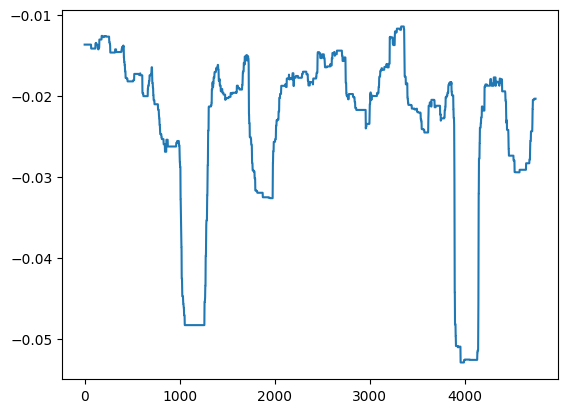

In [48]:
plt.plot(cvar)

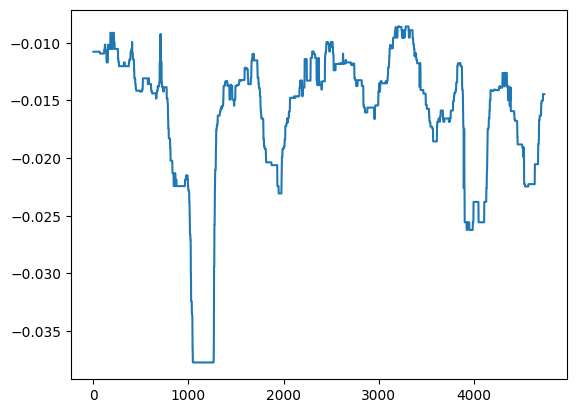

In [49]:
plt.plot(var)

In [118]:
bt_stats.periods.keys()

odict_keys(['1M', '3M', '6M', 'YTD', '1Y', '2Y', '3Y', '5Y', '7Y', '10Y', '15Y', '20Y', 'Inception'])

In [39]:
roll_returns = bt_stats.calc_rolling_returns(window_size='6M')

In [40]:
std_v = bt_stats.calc_rolling_std(window_size=252)

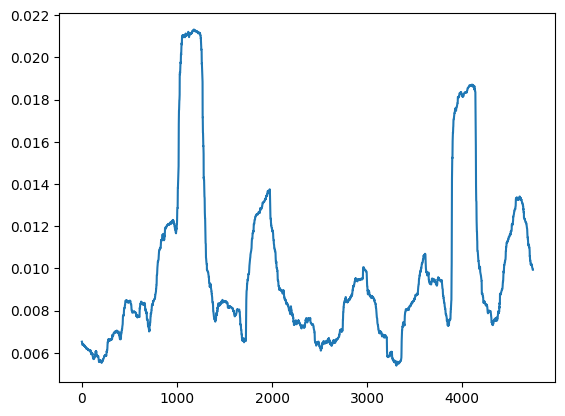

In [41]:
plt.plot(std_v)

In [51]:
np.corrcoef(std_v, cvar)

array([[ 1.        , -0.97314183],
       [-0.97314183,  1.        ]])

In [14]:
from numba import njit


def calc_cumulative_returns(
        returns_arr,
        axis=None
):
    return np.exp(np.sum(np.log(returns_arr + 1), axis=axis)) - 1


def calc_rolling_returns(
        rolling_windows
):
    rolling_returns_arr = calc_cumulative_returns(
        returns_arr=rolling_windows,
        axis=2
    )

    return rolling_returns_arr


def calc_rolling_std(
        rolling_windows
):
    rolling_std_arr = np.std(rolling_windows, axis=2)
    return rolling_std_arr


def calculate_var_cvar(returns, confidence_level=0.95):
    """
    Calculate the Value at Risk (VaR) and Conditional Value at Risk (CVaR) of a numpy returns array.

    Parameters:
    returns (numpy array): Array of returns
    confidence_level (float): Confidence level for VaR and CVaR (default is 0.95)

    Returns:
    tuple: (VaR, CVaR)
    """
    # Sort returns
    sorted_returns = np.sort(returns)

    # Calculate the index corresponding to the confidence level
    index = int((1 - confidence_level) * len(sorted_returns))

    # VaR is the value at the given confidence level
    var = sorted_returns[index]

    # CVaR is the average of returns worse than the VaR
    cvar = sorted_returns[:index].mean()

    return var, cvar

In [116]:
def calc_rolling_windows(
        returns_arr,
        periods_dict,
        periods_in_year=None
):
    if periods_in_year is None:
        periods_in_year = 252

    rolling_windows_dict = {k: {} for k in periods_dict.keys()}

    for period_name, period_info_dict in periods_dict.items():
        window_size = period_info_dict['Number of Years'] * periods_in_year
        rolling_windows_dict[period_name]['Rolling Window Length'] = window_size
        rolling_windows_dict[period_name]['Rolling Window'] = np.lib.stride_tricks.sliding_window_view(returns_arr,
                                                                                                       window_shape=window_size,
                                                                                                       axis=0)
    return rolling_windows_dict


def calc_rolling_stats(
        window_dict,
        func=calc_rolling_returns
):
    rolling_return_dict = {}

    for period_name in window_dict.keys():
        rolling_windows = window_dict[period_name]['Rolling Window']
        rolling_return_dict[period_name] = func(
            rolling_windows
        )
    return rolling_return_dict

# def calc_rolling_returns_stats(
#         window_dict,
# ):
#     rolling_return_dict = {}
# 
#     for period_name in window_dict.keys():
#         rolling_windows = window_dict[period_name]['Rolling Window']
#         rolling_return_dict[period_name] = calc_rolling_returns(
#             rolling_windows
#         )
#     return rolling_return_dict



In [117]:
window_dict = calc_rolling_windows(
    returns_arr=total_return_df.to_numpy(),
    window_size=252,
    periods_dict=period_dates
)

In [122]:
rolling_returns_dict = calc_rolling_stats(
    window_dict=window_dict,
    func=calc_rolling_returns
)